In [1]:
import qcodes as qc
import broadbean as bb
import logging
import os
import tempfile
from sequence_builder import SequenceBuilder
from broadbean.plotting import plotter
from alazar_config import alazarconfig
import numpy as np
import matplotlib.pyplot as plt
from qcodes.station import Station
from qcodes.utils.dataset.doNd import do0d, do1d
from qcodes import initialise_or_create_database_at, \
    load_or_create_experiment, Measurement, Parameter, \
    Station
from qcodes.dataset.plotting import plot_by_id


logging.basicConfig(level=logging.INFO)

In [2]:
db_path = os.path.join(tempfile.gettempdir(),
                       'data_access_example.db')
initialise_or_create_database_at(db_path)

experiment = load_or_create_experiment(
    experiment_name='alazar',
    sample_name='alazar-sample')

In [3]:
SC = qc.Station(config_file='ConfigRBC.yaml')
AWGB = SC.load_instrument('AWGB')
seqbuild = SequenceBuilder(name = 'seqbuild', awg=AWGB)
SC.add_component(seqbuild)
alazar = SC.load_instrument('alazar')
alazarconfig(alazar)
alazar_ctrl = SC.load_instrument('alazar_ctrl')
channelA = SC.load_instrument('channelA',parent=alazar_ctrl)
channelA2 = SC.load_instrument('channelA2',parent=alazar_ctrl)
channelA_phase = SC.load_instrument('channelA_phase',parent=alazar_ctrl)
channelA_magnitude = SC.load_instrument('channelA_magnitude',parent=alazar_ctrl)
channelA_real = SC.load_instrument('channelA_real',parent=alazar_ctrl)
channelA_imag = SC.load_instrument('channelA_imag',parent=alazar_ctrl)

INFO:qcodes.instrument.base.com.visa:[AWGB(AWG5208)] Opening PyVISA Resource Manager with default backend.
INFO:qcodes.instrument.base.com.visa:[AWGB(AWG5208)] Opening PyVISA resource at address: TCPIP0::192.168.15.118::inst0::INSTR
INFO:qcodes.instrument.base:[AWGB(AWG5208)] Connected to instrument: {'vendor': 'TEKTRONIX', 'model': 'AWG5208', 'serial': 'B020203', 'firmware': 'FV:6.1.0061.0'}


Connected to: TEKTRONIX AWG5208 (serial:B020203, firmware:FV:6.1.0061.0) in 0.22s


In [40]:
SC.seqbuild.cycle_time = 4e-6
SC.seqbuild.pulse_time = 0.6e-6
SC.seqbuild.readout_time = 1.5e-6
SC.seqbuild.marker_offset = 0e-9
SC.seqbuild.SR.set(1.5e9)


In [41]:
npts = 5
start = 4.5e3
stop = 5.0e6
SC.seqbuild.MultiQ_SSB_Spec_NoOverlap(start, stop, npts)

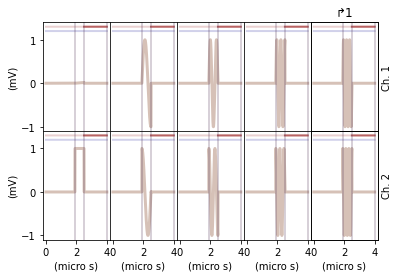

In [42]:
SC.seqbuild.seq.plot()

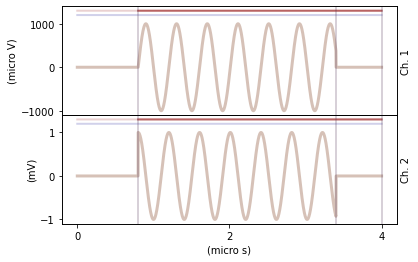

In [28]:
plotter(SC.seqbuild.seq.seq.element(50))


In [29]:
npts = 100
start = 0.0e-6
stop = 0.7e-6
SC.seqbuild.MultiQ_Lifetime_overlap(start, stop, npts)

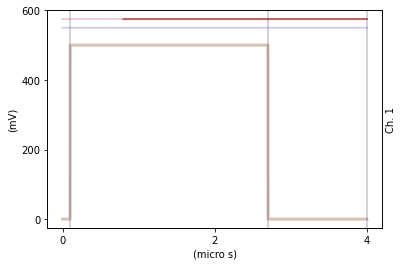

In [30]:
SC.seqbuild.seq.plot_elem_nr(100)

In [10]:
dis = SC.seqbuild.seq.snapshot()

In [11]:
snapseq = bb.Sequence().sequence_from_description(dis)


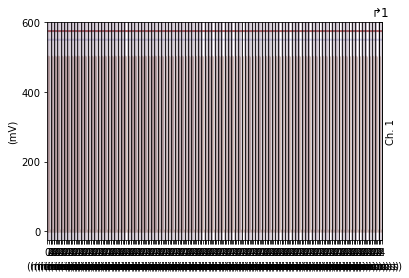

In [12]:
plotter(snapseq)

In [33]:
SC.seqbuild.seq_path = 'test.json'
SC.seqbuild.seq.from_file()

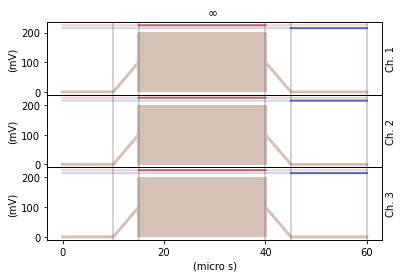

In [14]:
plotter(SC.seqbuild.seq.get())

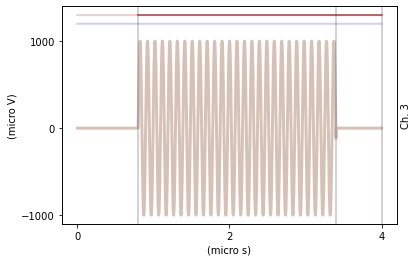

In [46]:
SC.seqbuild.cycle_time = 4e-6
SC.seqbuild.pulse_time = 2.6e-6
SC.seqbuild.readout_time = 0.6e-6
SC.seqbuild.marker_offset = -SC.seqbuild.pulse_time
SC.seqbuild.SR.set(1.5e9)
npts = 100
start = 0.6e6
stop = 20.0e6
SC.seqbuild.test_station(start, stop, npts,3)
SC.seqbuild.seq.plot_elem_nr(50)

In [47]:
SC.seqbuild.uploadToAWG()

Sequence uploaded in 1.503666877746582 seconds


In [48]:
SC.seqbuild.runAWG()

In [49]:
SC.seqbuild.awg.run_state()

'Running'

In [50]:
print(SC.seqbuild.awg.ch1.state())
print(SC.seqbuild.awg.ch2.state())
print(SC.seqbuild.awg.ch3.state())
print(SC.seqbuild.awg.ch4.state())

0
0
1
0


In [ ]:
SC.seqbuild.awg.stop()

In [51]:

alazar_ctrl.int_delay(0e-6)
alazar_ctrl.int_time(SC.seqbuild.pulse_time)
alazar_ctrl.channels.append(channelA_phase)
alazar_ctrl.channels.append(channelA_magnitude)
alazar_ctrl.channels.append(channelA_real)
alazar_ctrl.channels.append(channelA_imag)




INFO:qdev_wrappers.alazar_controllers.ATSChannelController:need 2600.0 samples round up to 2688
INFO:qdev_wrappers.alazar_controllers.ATSChannelController:need 2600.0 samples round up to 2688


INFO:qcodes.dataset.measurements:Registered alazar_ctrl_channelA_phase_records in the Measurement.
INFO:qcodes.dataset.measurements:Registered alazar_ctrl_channelA_phase_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 122 to 1612966555.7217438
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-01778c4c6ff6. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 100, 'buffers_per_acquisition': 8000, 'allocated_buffers': 4}


Starting experimental run with id: 122. 


INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-01778c4c6ff6. 


([<AxesSubplot:title={'center':'Run #122, Experiment alazar (alazar-sample)'}, xlabel='Records', ylabel='Phase (degr.)'>],
 [None])

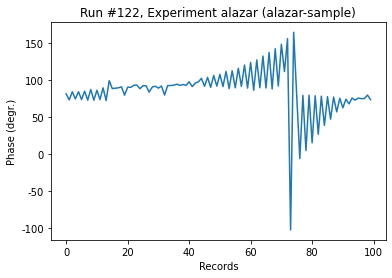

In [21]:
channelA_phase.records_per_buffer(npts)
channelA_phase.num_averages(8000)

channelA_phase.prepare_channel()
# Measure this 
data1 = do0d(channelA_phase.data)
#SC.seqbuild.runAWG()
plot_by_id(data1[0].run_id)

INFO:qcodes.dataset.measurements:Registered alazar_ctrl_channelA_magnitude_records in the Measurement.
INFO:qcodes.dataset.measurements:Registered alazar_ctrl_channelA_magnitude_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 124 to 1612979992.6289356
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-01778d1977f1. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 5, 'buffers_per_acquisition': 8000, 'allocated_buffers': 4}


Starting experimental run with id: 124. 


INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-01778d1977f1. 


([<AxesSubplot:title={'center':'Run #124, Experiment alazar (alazar-sample)'}, xlabel='Records', ylabel='f2 Readout Magnitude (μV)'>],
 [None])

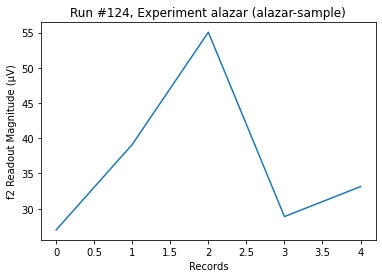

In [43]:
channelA_magnitude.records_per_buffer(npts)
channelA_magnitude.num_averages(8000)

channelA_magnitude.prepare_channel()
# Measure this 
data1 = do0d(channelA_magnitude.data)
#SC.seqbuild.runAWG()
plot_by_id(data1[0].run_id)

In [45]:
channelA_magnitude.data.get()

INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 5, 'buffers_per_acquisition': 8000, 'allocated_buffers': 4}


array([3.40742217e-05, 2.76256080e-05, 4.00008628e-05, 5.42496588e-05,
       2.98937980e-05])

In [34]:
from qcodes.dataset.data_set import load_by_id
data = load_by_id(102)

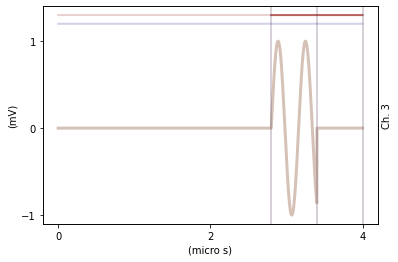

In [38]:
dis = data.snapshot['station']['instruments']['seqbuild']['parameters']['seq']
snapseq = bb.Sequence().sequence_from_description(dis)
plotter(snapseq.element(50))

In [39]:
dis

{'1': {'channels': {'3': {'segment_01': {'name': 'first',
     'function': 'function PulseAtoms.ramp',
     'durations': 2.7999999999999994e-06,
     'arguments': {'start': 0, 'stop': 0}},
    'segment_02': {'name': 'pulse',
     'function': 'function PulseAtoms.sine',
     'durations': 6e-07,
     'arguments': {'freq': 600000.0, 'ampl': 0.001, 'off': 0, 'phase': 0}},
    'segment_03': {'name': 'read',
     'function': 'function PulseAtoms.ramp',
     'durations': 6e-07,
     'arguments': {'start': 0, 'stop': 0}},
    'marker1_abs': [[2.7999999999999994e-06, 4e-06]],
    'marker2_abs': [],
    'marker1_rel': [[0, 0], [0, 0], [0, 0]],
    'marker2_rel': [[0, 0], [0, 0], [0, 0]]}},
  'sequencing': {'Wait trigger': 0,
   'Repeat': 1,
   'jump_input': 0,
   'jump_target': 0,
   'Go to': 0}},
 '2': {'channels': {'3': {'segment_01': {'name': 'first',
     'function': 'function PulseAtoms.ramp',
     'durations': 2.7999999999999994e-06,
     'arguments': {'start': 0, 'stop': 0}},
    'segment

INFO:qcodes.dataset.measurements:Registered alazar_ctrl_channelA2_records in the Measurement.
INFO:qcodes.dataset.measurements:Registered alazar_ctrl_channelA2_time in the Measurement.
INFO:qcodes.dataset.measurements:Registered alazar_ctrl_channelA2_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 126 to 1612980677.850503
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-01778d23eb4b. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 100, 'buffers_per_acquisition': 80, 'allocated_buffers': 4}


Starting experimental run with id: 126. 


INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-01778d23eb4b. 


([<AxesSubplot:title={'center':'Run #126, Experiment alazar (alazar-sample)'}, xlabel='Records', ylabel='Time (μS)'>],
 [<matplotlib.colorbar.Colorbar at 0x1d7a23c4948>])

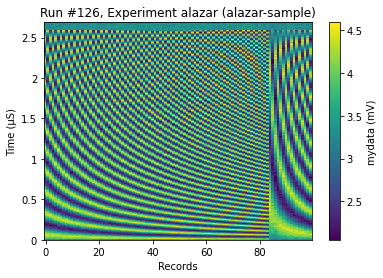

In [55]:
channelA2.records_per_buffer(npts)
channelA2.num_averages(80)

channelA2.prepare_channel()
# Measure this 
data1 = do0d(channelA2.data)
#SC.seqbuild.runAWG()
plot_by_id(data1[0].run_id)

In [75]:
stop = True

<IPython.core.display.Javascript object>


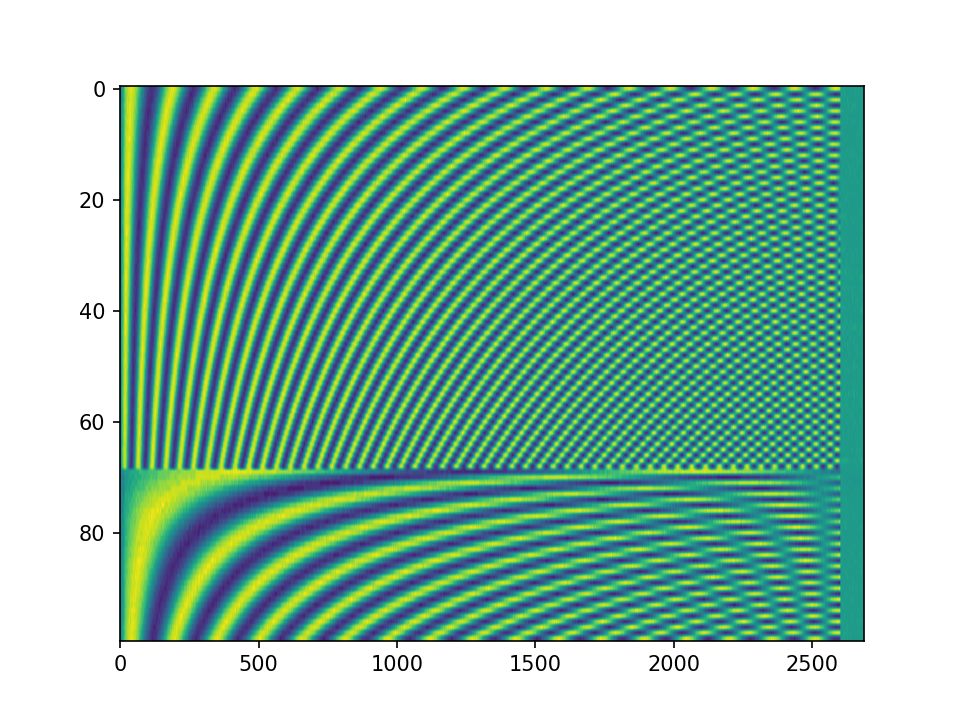

INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 100, 'buffers_per_acquisition': 80, 'allocated_buffers': 4}
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 100, 'buffers_per_acquisition': 80, 'allocated_buffers': 4}
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 100, 'buffers_per_acquisition': 80, 'allocated_buffers': 4}
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 100, 'buffers_per_acquisition': 80, 'allocated_buffers': 4}
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 100, 'buffers_per_acquisition': 80, 'allocated_buffers': 4}
INFO:qdev_wrapp

INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 100, 'buffers_per_acquisition': 80, 'allocated_buffers': 4}
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 100, 'buffers_per_acquisition': 80, 'allocated_buffers': 4}
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 100, 'buffers_per_acquisition': 80, 'allocated_buffers': 4}
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 100, 'buffers_per_acquisition': 80, 'allocated_buffers': 4}
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 100, 'buffers_per_acquisition': 80, 'allocated_buffers': 4}
INFO:qdev_wrapp

INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 100, 'buffers_per_acquisition': 80, 'allocated_buffers': 4}
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 100, 'buffers_per_acquisition': 80, 'allocated_buffers': 4}
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 100, 'buffers_per_acquisition': 80, 'allocated_buffers': 4}
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 100, 'buffers_per_acquisition': 80, 'allocated_buffers': 4}
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 2688, 'records_per_buffer': 100, 'buffers_per_acquisition': 80, 'allocated_buffers': 4}
INFO:qdev_wrapp

In [76]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure()
#fig.set_size_inches(18.5, 10.5)
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
#ax.axis('equal')
#ax.set_aspect('equal', 'box')
stop = False
for i in range(100):
    if stop:
        break
    bla = channelA2.data.get()
    ax.clear()
    ax.imshow(bla)
    ax.set_aspect(aspect='auto')
    fig.canvas.draw()